# 6. random forests

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
rcParams['figure.figsize'] = (7, 7)
font = {'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
from IPython.core.display import HTML
css_file = '../my.css'
HTML(open(css_file, "r").read())

In Informatica II we have discussed the decision tree learning algorithm for solving classification tasks. The model computed by this algorithm was a set of IF...THEN... rules structured in a top-down tree structure.

The idea behind decision tree contruction is to assign an entropy value to a set of data labels and use this entropy to find the best split at each node in the decision tree. 

Suppose we have a data set with 100 samples of which 20 belong to class 1 and 80 belong to class 2. For this data set the probability $p_1$ that a data point belongs to class 1 is 0.2, the probability $p_2$ that a data point belongs to class 2 is 0.8. 

The entropy $H$ of the data set is computed from these two probabilities as

$$H(p) = -\sum_i p_i log_2(p_i)$$

where $i$ ranges over the probabilities (so this also works for data sets with more than 2 classes).

Let's compute the entropy for our data set:

In [2]:
entropy = lambda p: -np.sum(p * np.log2(p)) if not 0 in p else 0

In [3]:
entropy([.2,.8])

0.72192809488736231

Now suppose our data set conained only one samples for class 1 and 99 for class 2:

entropy([0.01, 0.99])

The entropy for this data set is much lower. To maximize the entropy of a data set we have to create one with an equal number of samples for class 1 and 2:

In [4]:
entropy([0.5, 0.5])

1.0

The entropy function for two classes looks like this:

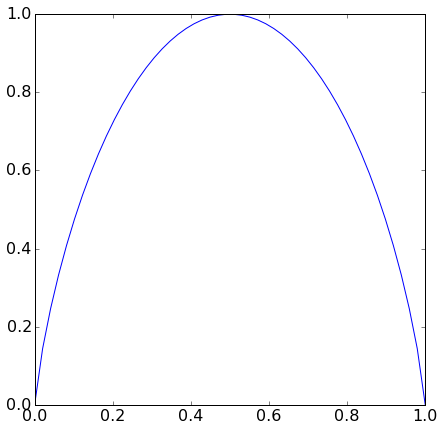

In [5]:
pvals = np.linspace(0, 1)        
plt.plot(pvals, [entropy([p,1-p]) for p in pvals])

Remember that a decision tree was constructed by recursively splitting (partitioning) a data set $D$. For each split the learning algorithm finds the feature that *best* partitioned the data set. To find this feature we a criterion called **information gain**.

Information gain is the difference between the current entropy of a system and the entropy measured after a feature is chosen. If $D$ is a set of samples and $x$ is a possible feature on which to partition the data set, then:

$$G(D,x) = \text{Entropy}(D) - \sum_{v \in x} \frac{|D_v|}{|D|} \text{Entropy}(D_v)$$

where $v$ is a particular value of $x$.



The decision tree learning algorithm computes the information gain for each feature and selects the one with the highest value. In this way, it searches the "tree space" according to a greedy strategy.

A tree can be constructed by recursively selecting the feature from the current data set with the largest information gain, then removing it from the data set. Recursion stops when there are either no variables remaining, or there is only one class left in the subset.

Refer to Informatica II for the details on how to construct a decision tree using the information gain criterion.

Decision trees can become very complex and we have seen in Informatica II that they are prone to overfit the train set. To prevent overfitting, we can stop growing the tree if the information gain is not sufficient to justify the extra complexity of adding another node. Or, as we have seen, we can also stop constructing the tree when some tree depth is obtained.

In scikit-learn a decision tree can be constructed using the *DecisionTreeClassifier* object in the *tree* module.

Let's build a decision tree on the wine dataset.

In [6]:
wine = pd.read_table("wine.dat", sep='\s+')

attributes = ['Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']

grape = wine.pop('region')
y = grape
wine.columns = attributes
X = wine

In [7]:
from sklearn import tree
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        X, y, test_size=0.4, random_state=0)

clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_features="auto",
                                  min_samples_leaf=10)
clf.fit(X_train, y_train)

DecisionTreeClassifier(compute_importances=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_density=None, min_samples_leaf=10, min_samples_split=2,
            random_state=None, splitter='best')

If you have [GraphViz](http://www.graphviz.org) installed, you can draw the resulting tree:

In [8]:
with open("wine.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

In [9]:
! dot -Tpng wine.dot -o wine.png

'dot' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
for i,x in enumerate(X.columns):
    print(i,x)

(0, 'Alcohol')
(1, 'Malic acid')
(2, 'Ash')
(3, 'Alcalinity of ash')
(4, 'Magnesium')
(5, 'Total phenols')
(6, 'Flavanoids')
(7, 'Nonflavanoid phenols')
(8, 'Proanthocyanins')
(9, 'Color intensity')
(10, 'Hue')
(11, 'OD280/OD315 of diluted wines')
(12, 'Proline')


In [11]:
from IPython.core.display import Image
Image("wine.png")

In [ ]:
preds = clf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['actual'], 
            colnames=['prediction'])

Decision trees have several advantages: 

* ease of interpretation
* handles continuous and discrete features
* invariant to monotone transformation of features
* variable selection automated
* robust
* scalable

However, relative to other learning algorithms, decision trees do not predict very accurately, due to the greedy nature of the tree construction algorithm. Also, trees tend to be **unstable**, as small changes to the inputs can have large effects on the structure of the tree; poor decisions near the root of the tree will propogate to the rest of the tree. 
Decision trees therefor called **high variance** models.

One way to reduce the variance of a model is to average together many models. In the case of decision trees, we can train $T$ different trees on random subsets of the data (with replacement) then average according to:

$$\hat{f}(x,\theta) = \frac{1}{T} \sum_{i=1}^T f_t(x,\theta)$$

where $f_t$ is the $t^{th}$ tree. This approach is called "bootstrap aggregating" ( or **bagging**) and can be applied to many other learning algorithms that show high variance.

Note that, since we are averaging over trees, there is *no need to prune*. With bagging, we reduce variance by averaging, rather than by pruning.

In [ ]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(n_jobs=4, oob_score=True)
bc

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=4, oob_score=True, random_state=None,
         verbose=0)

In [ ]:
bc.fit(X_train, y_train)

preds = bc.predict(X_test)
pd.crosstab(y_test, preds, rownames=['actual'], 
            colnames=['prediction'])

Test error of a bagged model is measured by estimating **out-of-bag error**.

On average, each bagged tree uses about 2/3 of observations, leaving the remaining third as "out-of bag". The response for the ith observation for each of the trees in which that observation was excluded (on average, B/3) is averaged. This essentially the same as performing leave-one-out (LOO) cross-validation.

In [ ]:
bc.oob_score_

**Random forests** improves upon bagging by creating a set of trees that are less correlated than bootstrapped trees. This is done by selecting from only a subset m of M possible predictors at each split. Typically, we choose approximately the square root of the available number.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=4)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['actual'], 
            colnames=['prediction'])

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

h = 0.2

def create_heatmap(X):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    return np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

def plot_decision_boundary(clf,X,y):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])   
    #if hasattr(clf, "decision_function"):
    #    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    #else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

(X,y) = make_moons(n_samples=1000, noise=0.3, random_state=2)
X = StandardScaler().fit_transform(X)

(xx,yy) = create_heatmap(X)

plt.figure(figsize=(24,12))

plt.subplot(1,2,1)
model = tree.DecisionTreeClassifier(criterion='entropy')
model.fit(X,y)
plot_decision_boundary(model,X,y)

plt.subplot(1,2,2)
model = RandomForestClassifier(n_estimators=100)
model.fit(X,y)
plot_decision_boundary(model,X,y)

plt.show()

In [ ]:
from sklearn.datasets import make_classification

(X,y) = make_classification(
n_samples=1000,
n_features=5000,
n_classes=2,
n_informative=2,
n_redundant=285,
n_repeated=5,
class_sep=0.4,
n_clusters_per_class=2,
shift=uniform(0, 100),
scale=None,
random_state=1
)
X = (X - X.mean()) / (X.max() - X.min())

In [ ]:
from sklearn.cross_validation import KFold

n_folds = 5
kf = KFold(len(X), n_folds=n_folds,shuffle=True,random_state=1)

model = tree.DecisionTreeClassifier(criterion='entropy')
print "Accuracy scores for DecisionTreeClassifier:"
for train, test in kf:
    model.fit(X[train], y[train])
    print model.score(X[test],y[test])

model = RandomForestClassifier(n_estimators=100)
print "Accuracy scores for RandomForestClassifier:"
for train, test in kf:
    model.fit(X[train], y[train])
    print model.score(X[test],y[test])